## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import log_loss, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold

## Load data set

In [2]:
# Cleansed data
data = pd.read_csv('../data/small_training_cleansed.zip', compression='zip')

# Cleansed and standardized data
data_stdz = pd.read_csv('../data/small_training_cleansed_stdz.zip', compression='zip')

## Function that select features which have lowest correlation between each other

In [3]:
def get_low_corr_df(d):
    # Remove class2 because we dont want to drop features that correlate with class2
    d = d.drop('class2', axis=1)

    # Create correlation matrix
    corr_matrix = d.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation greater than 0.35
    to_drop = [column for column in upper.columns if any(upper[column] > 0.35)]

    # Remove features that have great correlation
    d = d.drop(d[to_drop], axis=1)

    # Add class2 back to the dataframe
    d['class2'] = data['class2']

    return d

## Create new dataframes that have columns whith low correlation

In [4]:
data_low_corr = get_low_corr_df(data)
data_low_corr_stdz = get_low_corr_df(data_stdz)

## Look at all of the data.

In [5]:
data.describe()

,CO2504.mean,Glob.mean,H2O672.mean,NET.mean,NO672.mean,NOx672.mean,O3672.mean,Pamb0.mean,PAR.mean,PTG.mean,RGlob.mean,RHIRGA672.mean,RPAR.mean,SO2168.mean,SWS.mean,T672.mean,UV_A.mean,CS.mean,class2
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,380.913345,193.287920,7.160940,122.390867,0.055901,1.266881,34.353575,991.354278,382.301574,-0.000372,27.427025,69.686362,18.259929,0.190684,914.221105,6.311782,10.961236,0.002974,0.500000
std,10.900973,126.058537,3.798081,86.464582,0.049923,0.983461,9.079498,9.686386,247.429828,0.003309,16.608088,20.185316,11.011583,0.177113,13.483655,9.680534,6.633754,0.001941,0.500547
min,356.841429,3.719434,1.000147,-47.799712,-0.012456,0.079111,10.406360,967.083487,7.530252,-0.007723,-1.122083,26.695342,0.000000,-0.020408,886.641871,-23.288234,0.295780,0.000227,0.000000
25%,372.921420,71.773357,4.004424,47.394350,0.018626,0.483321,28.521357,985.171848,142.709806,-0.002661,12.388924,52.135258,9.826067,0.056376,908.504834,-1.298557,4.937496,0.001500,0.000000
50%,380.113959,197.939217,6.279441,124.559808,0.039294,1.004342,34.320171,991.517281,395.843812,0.000000,28.415197,69.926589,17.740020,0.128417,918.368227,7.320084,11.702413,0.002475,0.500000
75%,388.296775,304.162015,9.949462,194.753205,0.076252,1.714546,40.598021,997.230756,595.037771,0.001170,41.957688,88.316804,24.608422,0.256596,923.080143,13.964999,16.727710,0.004176,1.000000
max,411.348676,449.450545,18.864270,296.188303,0.162691,3.561385,58.713018,1015.319117,830.082577,0.006916,83.859893,104.185588,46.781954,0.556927,934.925926,25.684185,22.560576,0.008191,1.000000


In [6]:
data_low_corr.describe()

,CO2504.mean,Pamb0.mean,PTG.mean,class2
count,458.000000,458.000000,458.000000,458.000000
mean,380.913345,991.354278,-0.000372,0.500000
std,10.900973,9.686386,0.003309,0.500547
min,356.841429,967.083487,-0.007723,0.000000
25%,372.921420,985.171848,-0.002661,0.000000
50%,380.113959,991.517281,0.000000,0.500000
75%,388.296775,997.230756,0.001170,1.000000
max,411.348676,1015.319117,0.006916,1.000000


In [7]:
data_stdz.describe()

,CO2504.mean,Glob.mean,H2O672.mean,NET.mean,NO672.mean,NOx672.mean,O3672.mean,Pamb0.mean,PAR.mean,PTG.mean,RGlob.mean,RHIRGA672.mean,RPAR.mean,SO2168.mean,SWS.mean,T672.mean,UV_A.mean,CS.mean,class2
count,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,458.000000
mean,-3.104504e-15,1.923498e-16,-1.270211e-16,-4.272419e-17,5.032971e-17,7.138879e-17,1.467773e-16,9.785355e-15,1.510800e-16,-7.757017e-18,1.129616e-16,8.120627e-18,1.357478e-17,1.225669e-17,4.048193e-17,-1.539283e-16,-4.305750e-17,-2.060458e-17,0.500000
std,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,0.500547
min,-2.210650e+00,-1.505458e+00,-1.623854e+00,-1.970479e+00,-7.864856e-01,-9.504599e-01,-3.298151e+00,-3.598607e+00,-1.516313e+00,-1.291098e+00,-1.720868e+00,-2.132145e+00,-1.444496e+00,-7.067659e-01,-1.224585e+01,-3.061028e+00,-1.609514e+00,-1.252403e+00,0.000000
25%,-7.339404e-01,-9.650075e-01,-8.319906e-01,-8.683154e-01,-4.987371e-01,-6.540443e-01,-6.310298e-01,-6.207807e-01,-9.693809e-01,-4.620394e-01,-9.064587e-01,-8.704494e-01,-6.873181e-01,-5.069787e-01,-3.327239e-02,-7.870084e-01,-9.090368e-01,-6.879132e-01,0.000000
50%,-7.341183e-02,3.693826e-02,-2.323444e-01,2.511216e-02,-3.073958e-01,-2.719678e-01,-4.198333e-03,2.201776e-02,5.479148e-02,-2.623961e-02,5.956450e-02,1.191411e-02,-7.748430e-02,-3.195320e-01,2.833965e-01,1.042716e-01,1.118503e-01,-2.554536e-01,0.500000
75%,6.780591e-01,8.805063e-01,7.349951e-01,8.378167e-01,3.474595e-02,2.488403e-01,6.744151e-01,6.007984e-01,8.607241e-01,1.654096e-01,8.758715e-01,9.239793e-01,4.517813e-01,1.398170e-02,4.346747e-01,7.914425e-01,8.702130e-01,4.995424e-01,1.000000
max,2.795036e+00,2.034315e+00,3.084749e+00,2.012240e+00,9.023683e+00,7.581211e+00,4.173599e+00,2.582962e+00,1.811708e+00,1.360699e+01,3.401630e+00,1.710994e+00,8.008621e+00,9.182374e+00,8.149892e-01,2.003359e+00,1.750445e+00,7.117433e+00,1.000000


In [8]:
data_low_corr_stdz.describe()

,CO2504.mean,NO672.mean,Pamb0.mean,PTG.mean,SWS.mean,class2
count,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,4.580000e+02,458.000000
mean,-3.104504e-15,5.032971e-17,9.785355e-15,-7.757017e-18,4.048193e-17,0.500000
std,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,1.001093e+00,0.500547
min,-2.210650e+00,-7.864856e-01,-3.598607e+00,-1.291098e+00,-1.224585e+01,0.000000
25%,-7.339404e-01,-4.987371e-01,-6.207807e-01,-4.620394e-01,-3.327239e-02,0.000000
50%,-7.341183e-02,-3.073958e-01,2.201776e-02,-2.623961e-02,2.833965e-01,0.500000
75%,6.780591e-01,3.474595e-02,6.007984e-01,1.654096e-01,4.346747e-01,1.000000
max,2.795036e+00,9.023683e+00,2.582962e+00,1.360699e+01,8.149892e-01,1.000000


## Plot the correlation matrices.

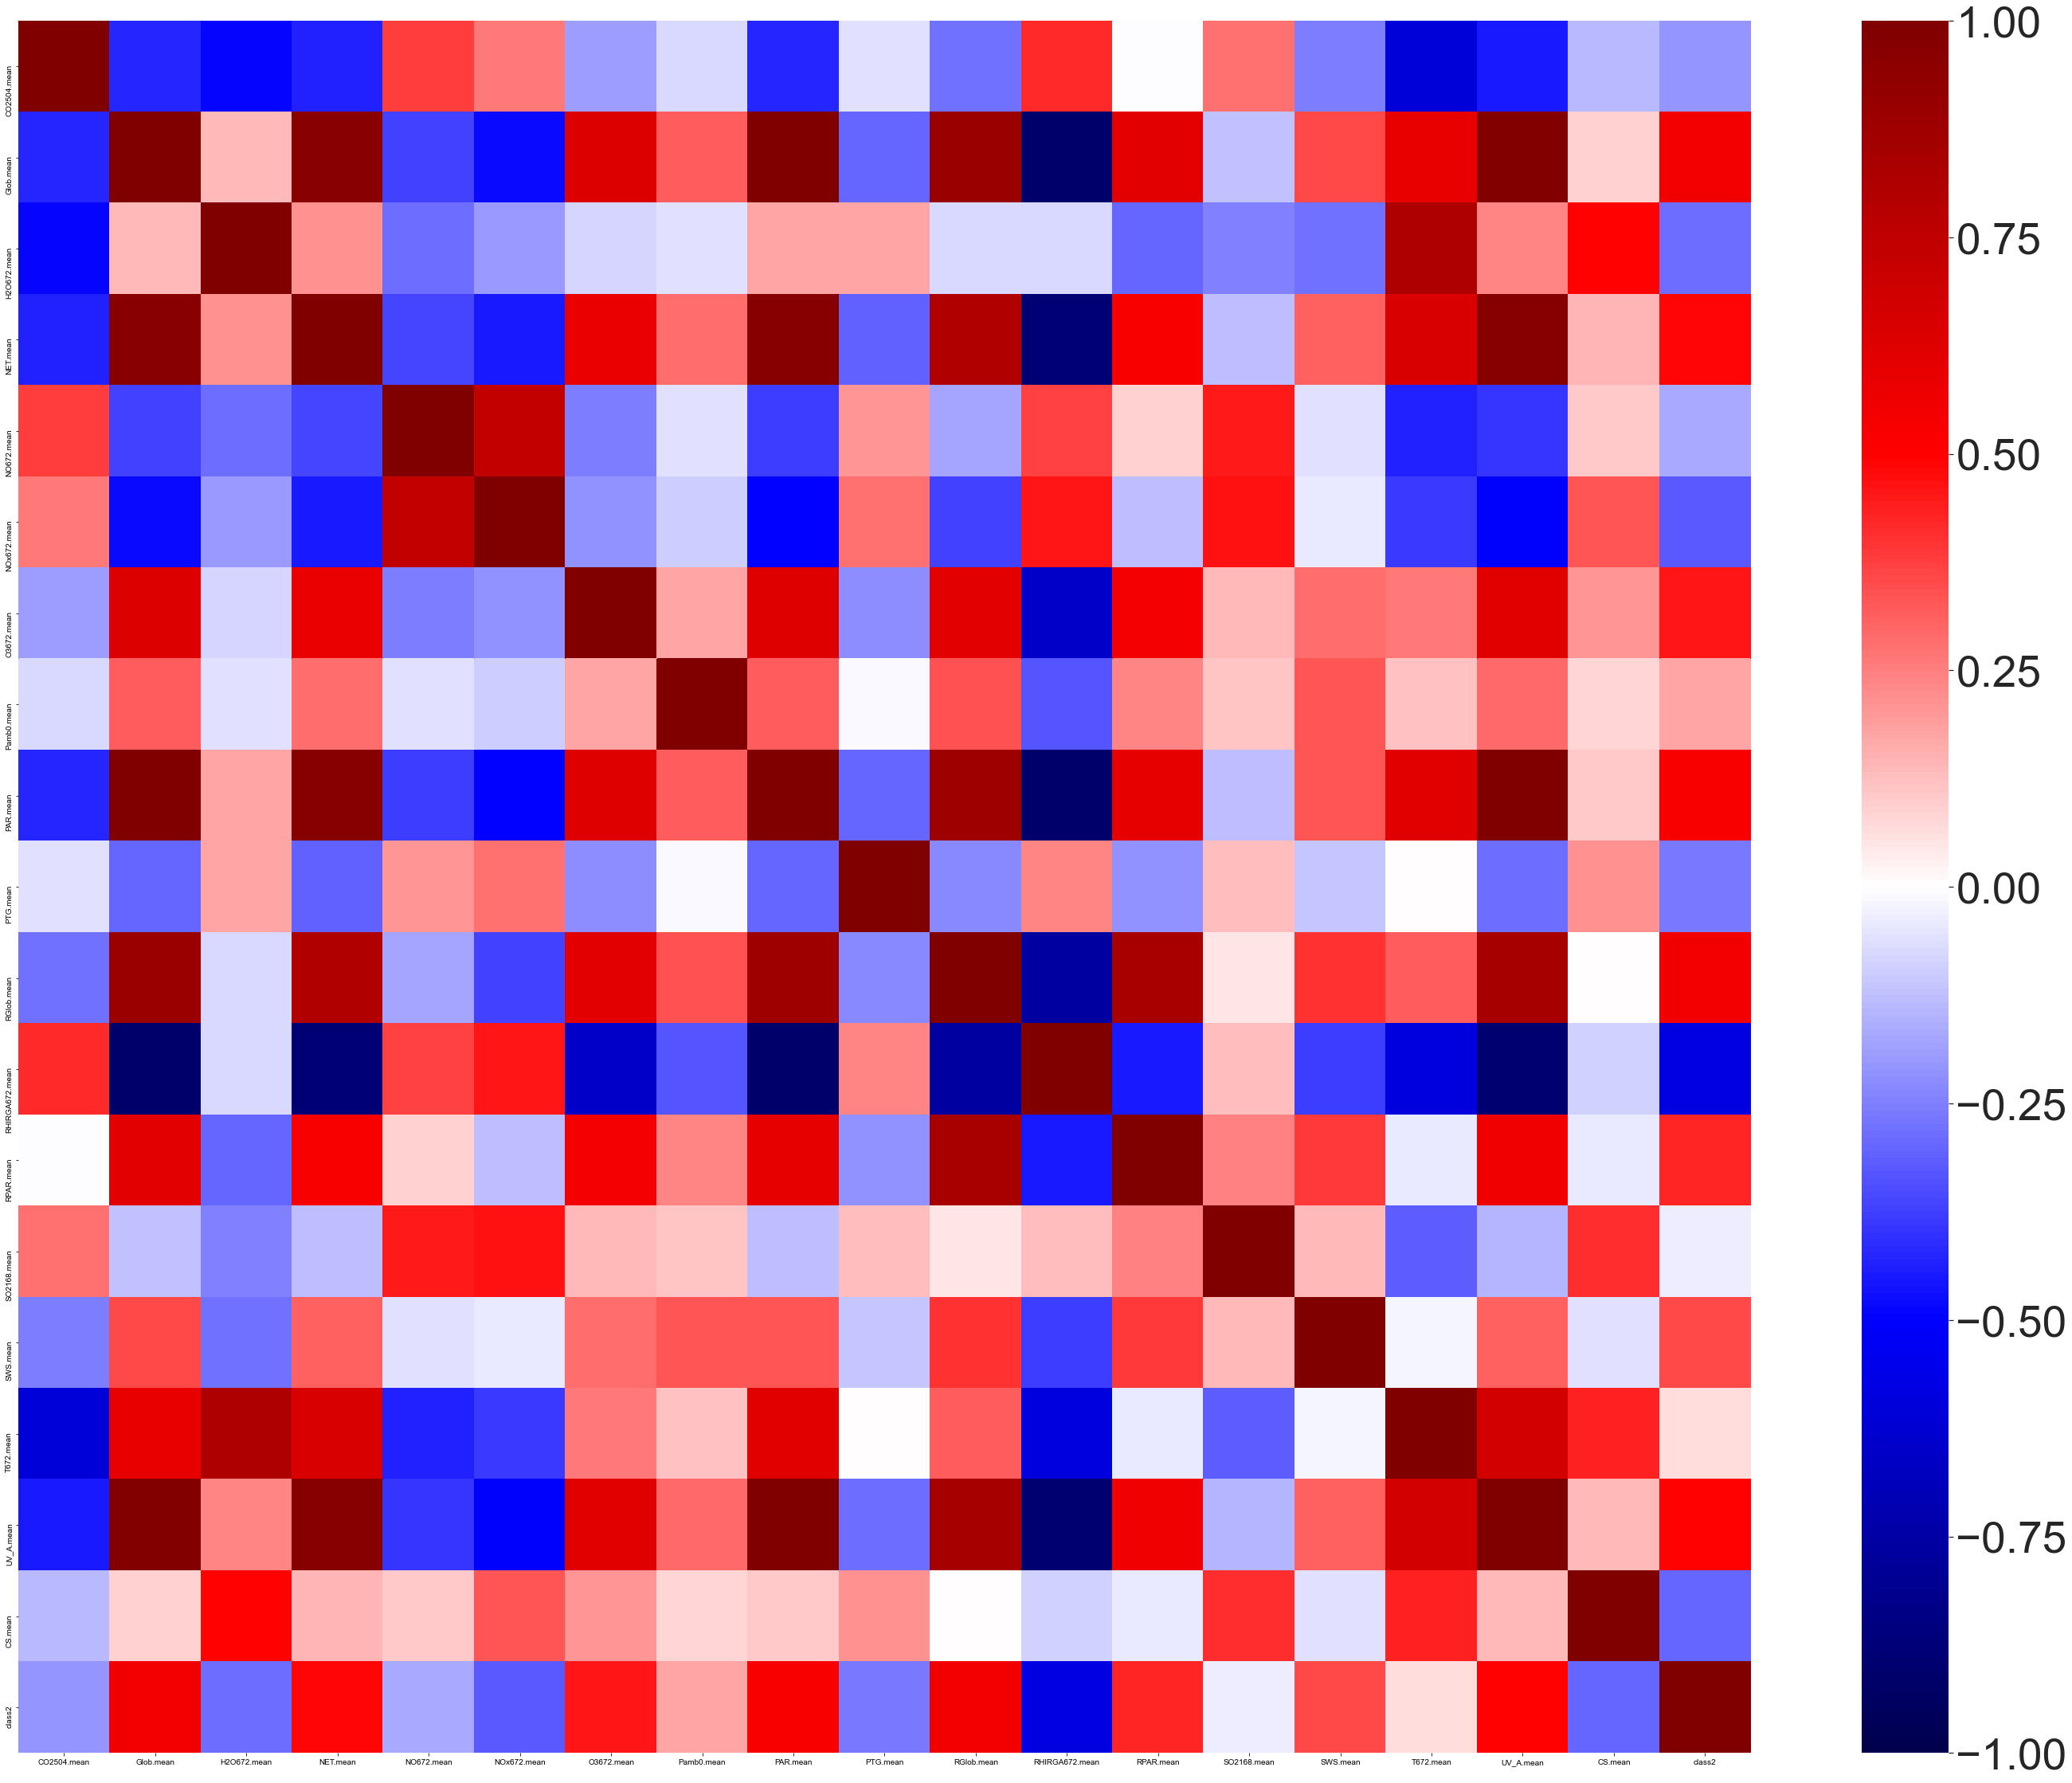

In [9]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(50, 40))
sns.set(font_scale=5)
ax = sns.heatmap(corr_matrix, cmap='seismic', vmin=-1, vmax=1, square=True)

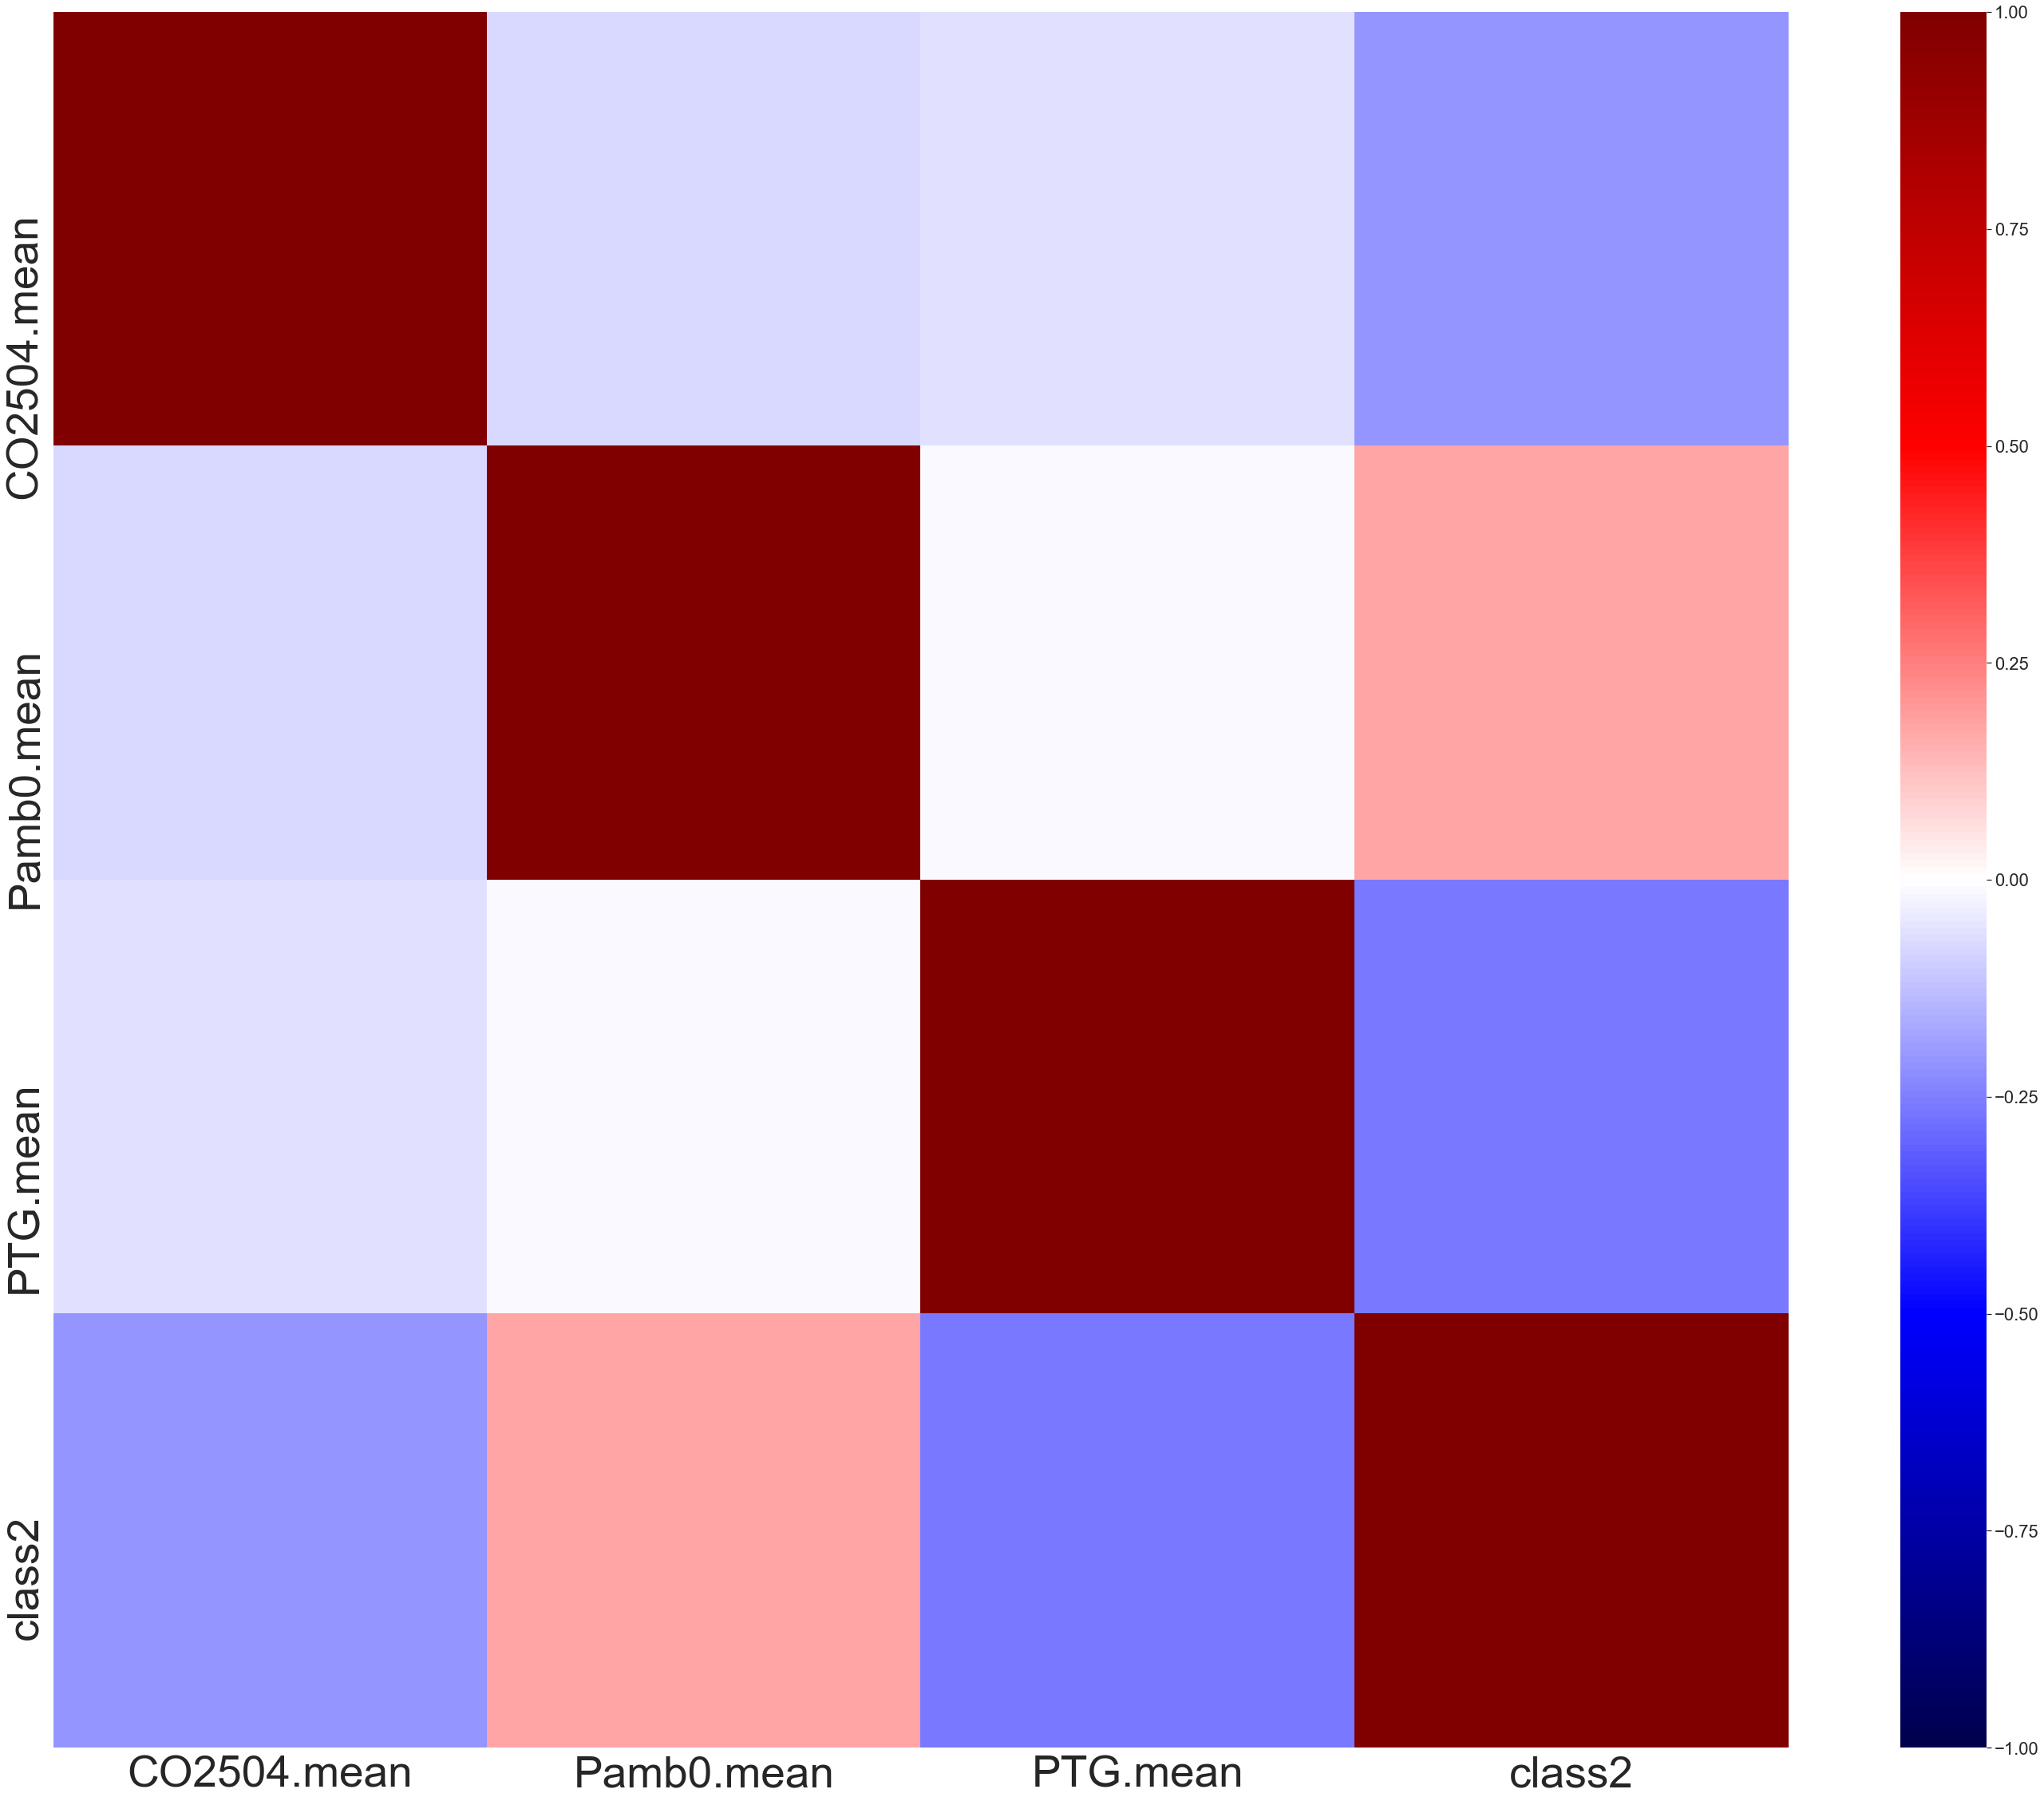

In [10]:
corr_matrix = data_low_corr.corr()
f, ax = plt.subplots(figsize=(50, 40))
sns.set(font_scale=2)
ax = sns.heatmap(corr_matrix, cmap='seismic', vmin=-1, vmax=1, square=True)

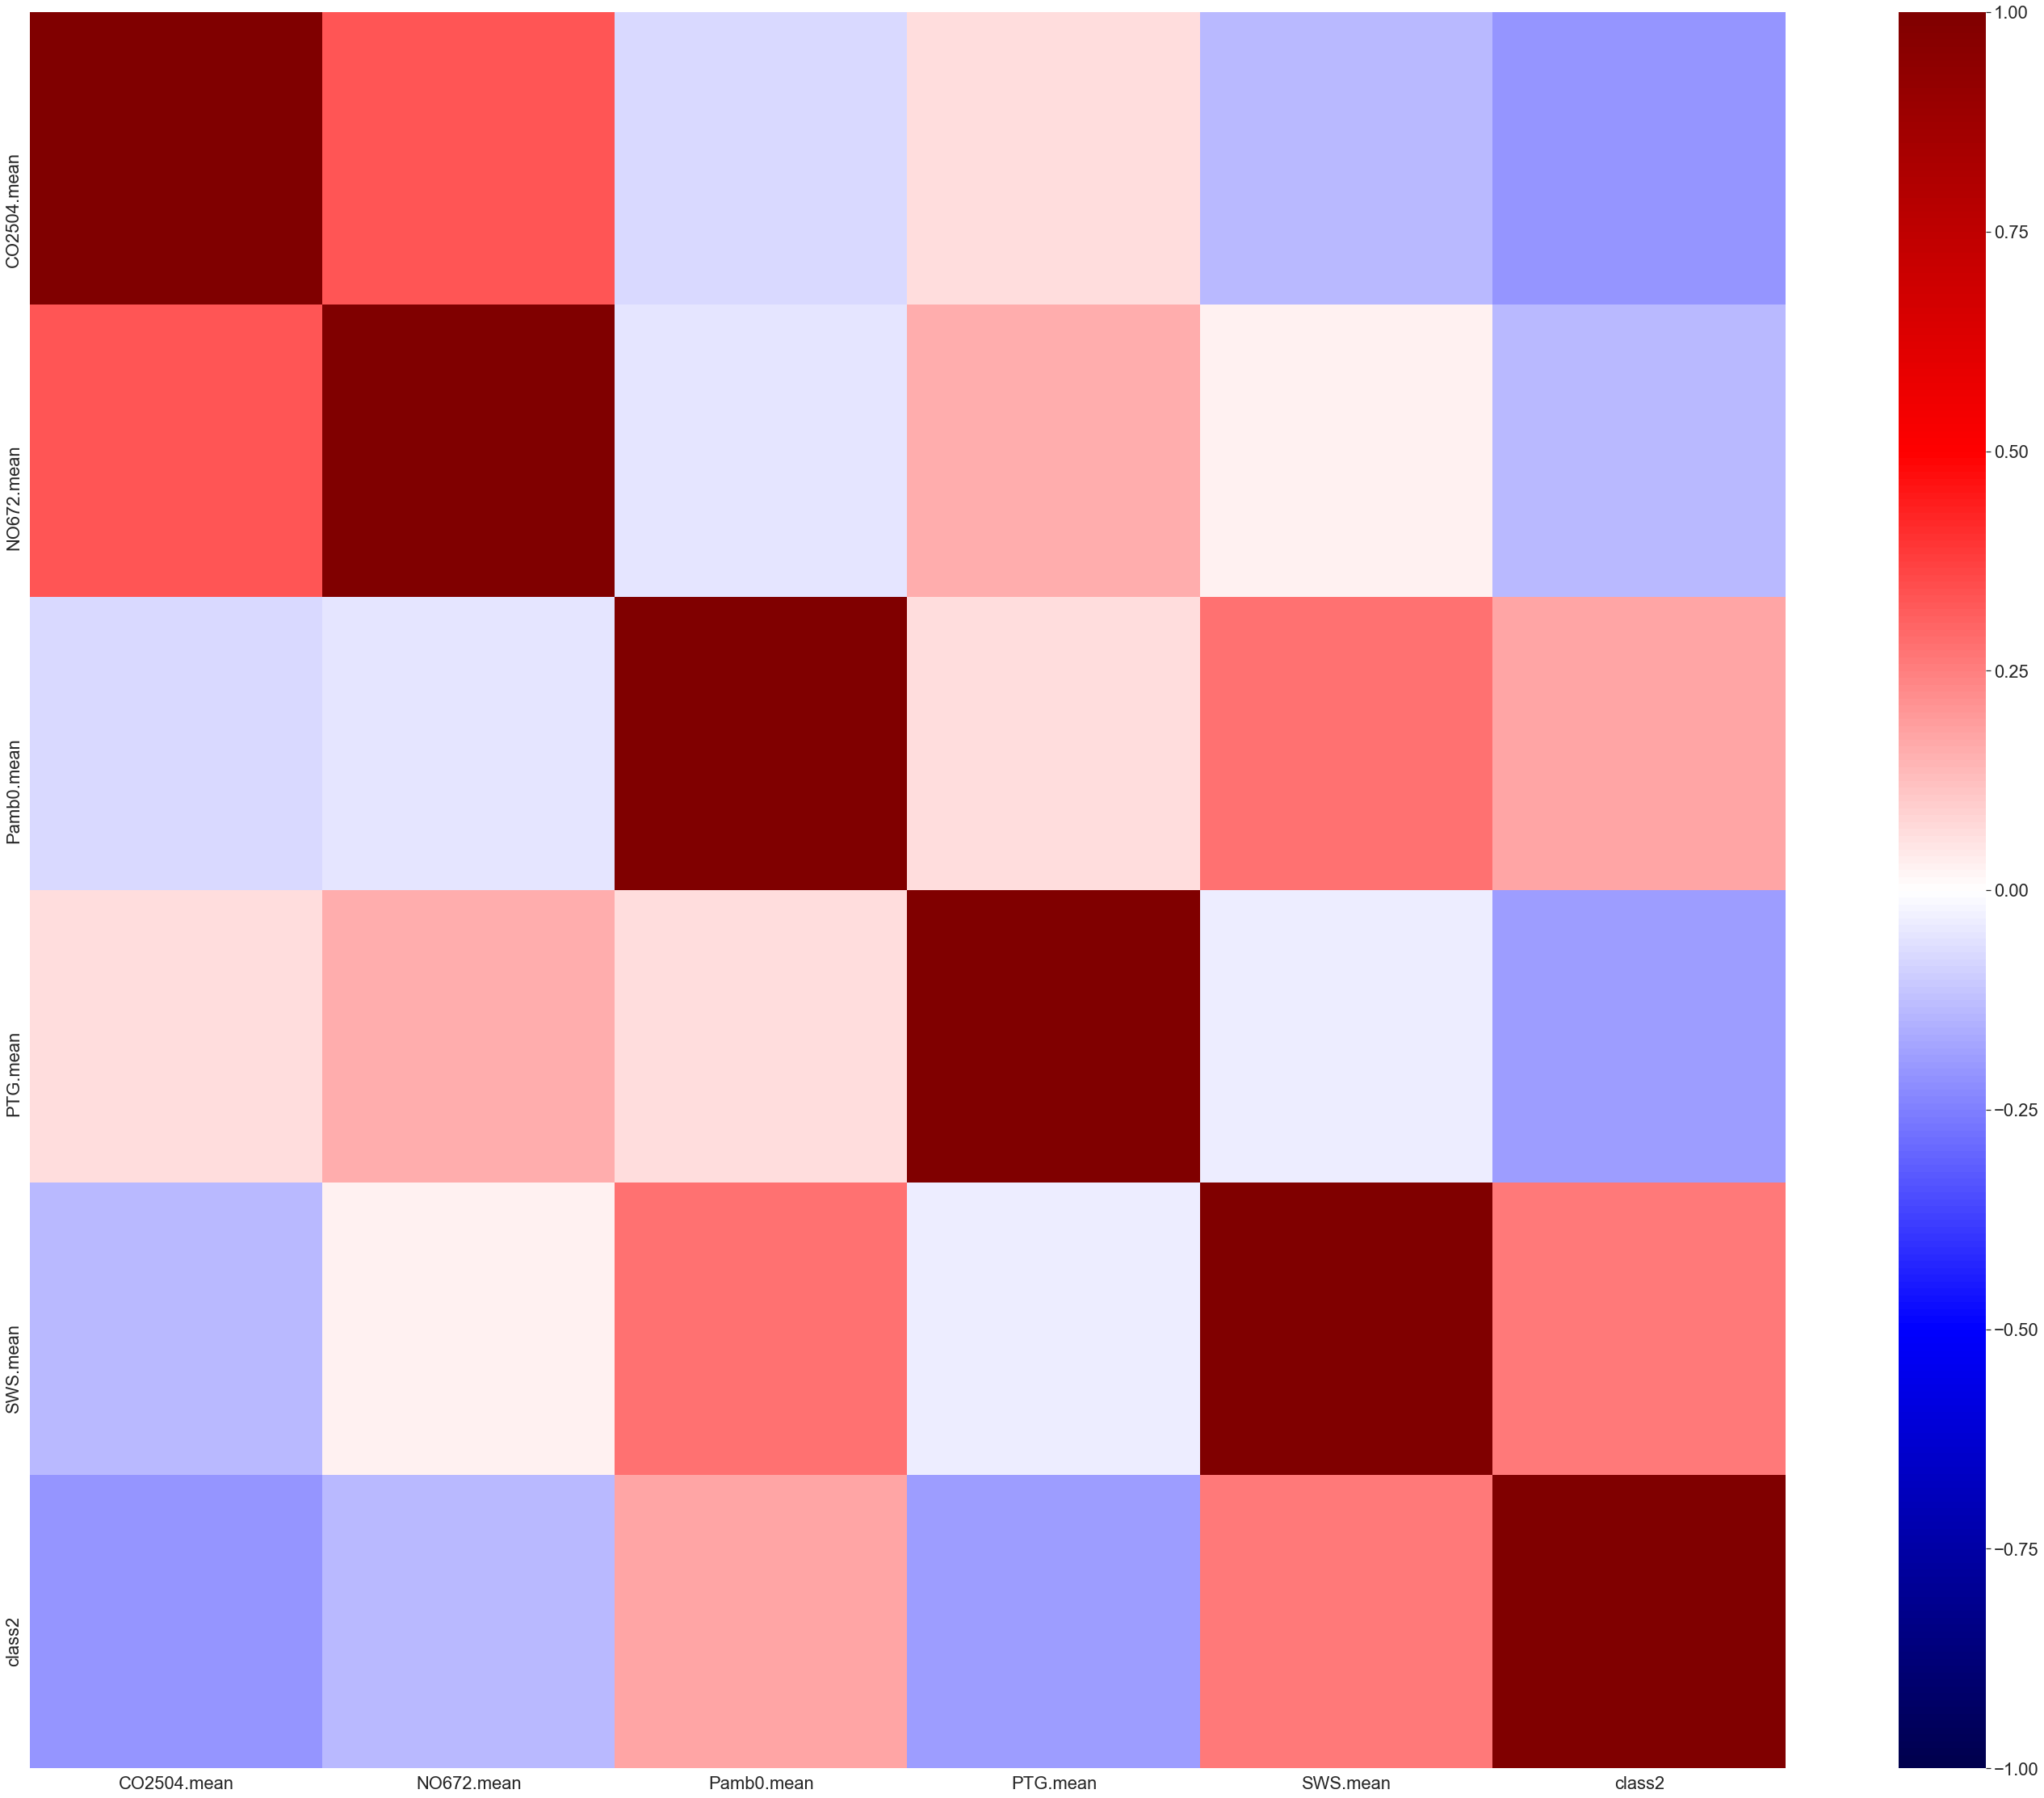

In [11]:
corr_matrix = data_low_corr_stdz.corr()
f, ax = plt.subplots(figsize=(50, 40))
sns.set(font_scale=2)
ax = sns.heatmap(corr_matrix, cmap='seismic', vmin=-1, vmax=1, square=True)

In [12]:
# Function to get train test split
def get_tts(df: pd.DataFrame):
    X = df.drop('class2', axis=1).values
    y = df['class2'].values
    return train_test_split(X, y, test_size=0.3, random_state=0) 

# Naive bayes model
gnb = GaussianNB(priors=[0.6, 0.4])

# Split training and test data
X_train, X_test, y_train, y_test = get_tts(data)
X_train_lowcorr, X_test_lowcorr, y_train_lowcorr, y_test_lowcorr = get_tts(data_low_corr)
X_train_stdz, X_test_stdz, y_train_stdz, y_test_stdz = get_tts(data_stdz)
X_train_lowcorr_stdz, X_test_lowcorr_stdz, y_train_lowcorr_stdz, y_test_lowcorr_stdz = get_tts(data_low_corr_stdz)

# Predict
y_pred = gnb.fit(X_train, y_train).predict(X_test)
y_pred_lowcorr = gnb.fit(X_train_lowcorr, y_train_lowcorr).predict(X_test_lowcorr)
y_pred_stdz = gnb.fit(X_train_stdz, y_train_stdz).predict(X_test_stdz)
y_pred_lowcorr_stdz = gnb.fit(X_train_lowcorr_stdz, y_train_lowcorr_stdz).predict(X_test_lowcorr_stdz)

# Predictable classes
print('Predictable classes of the model: ', gnb.classes_)


Predictable classes of the model:  [0 1]


## Confusion Matrices and ROC curves

<Figure size 432x288 with 0 Axes>

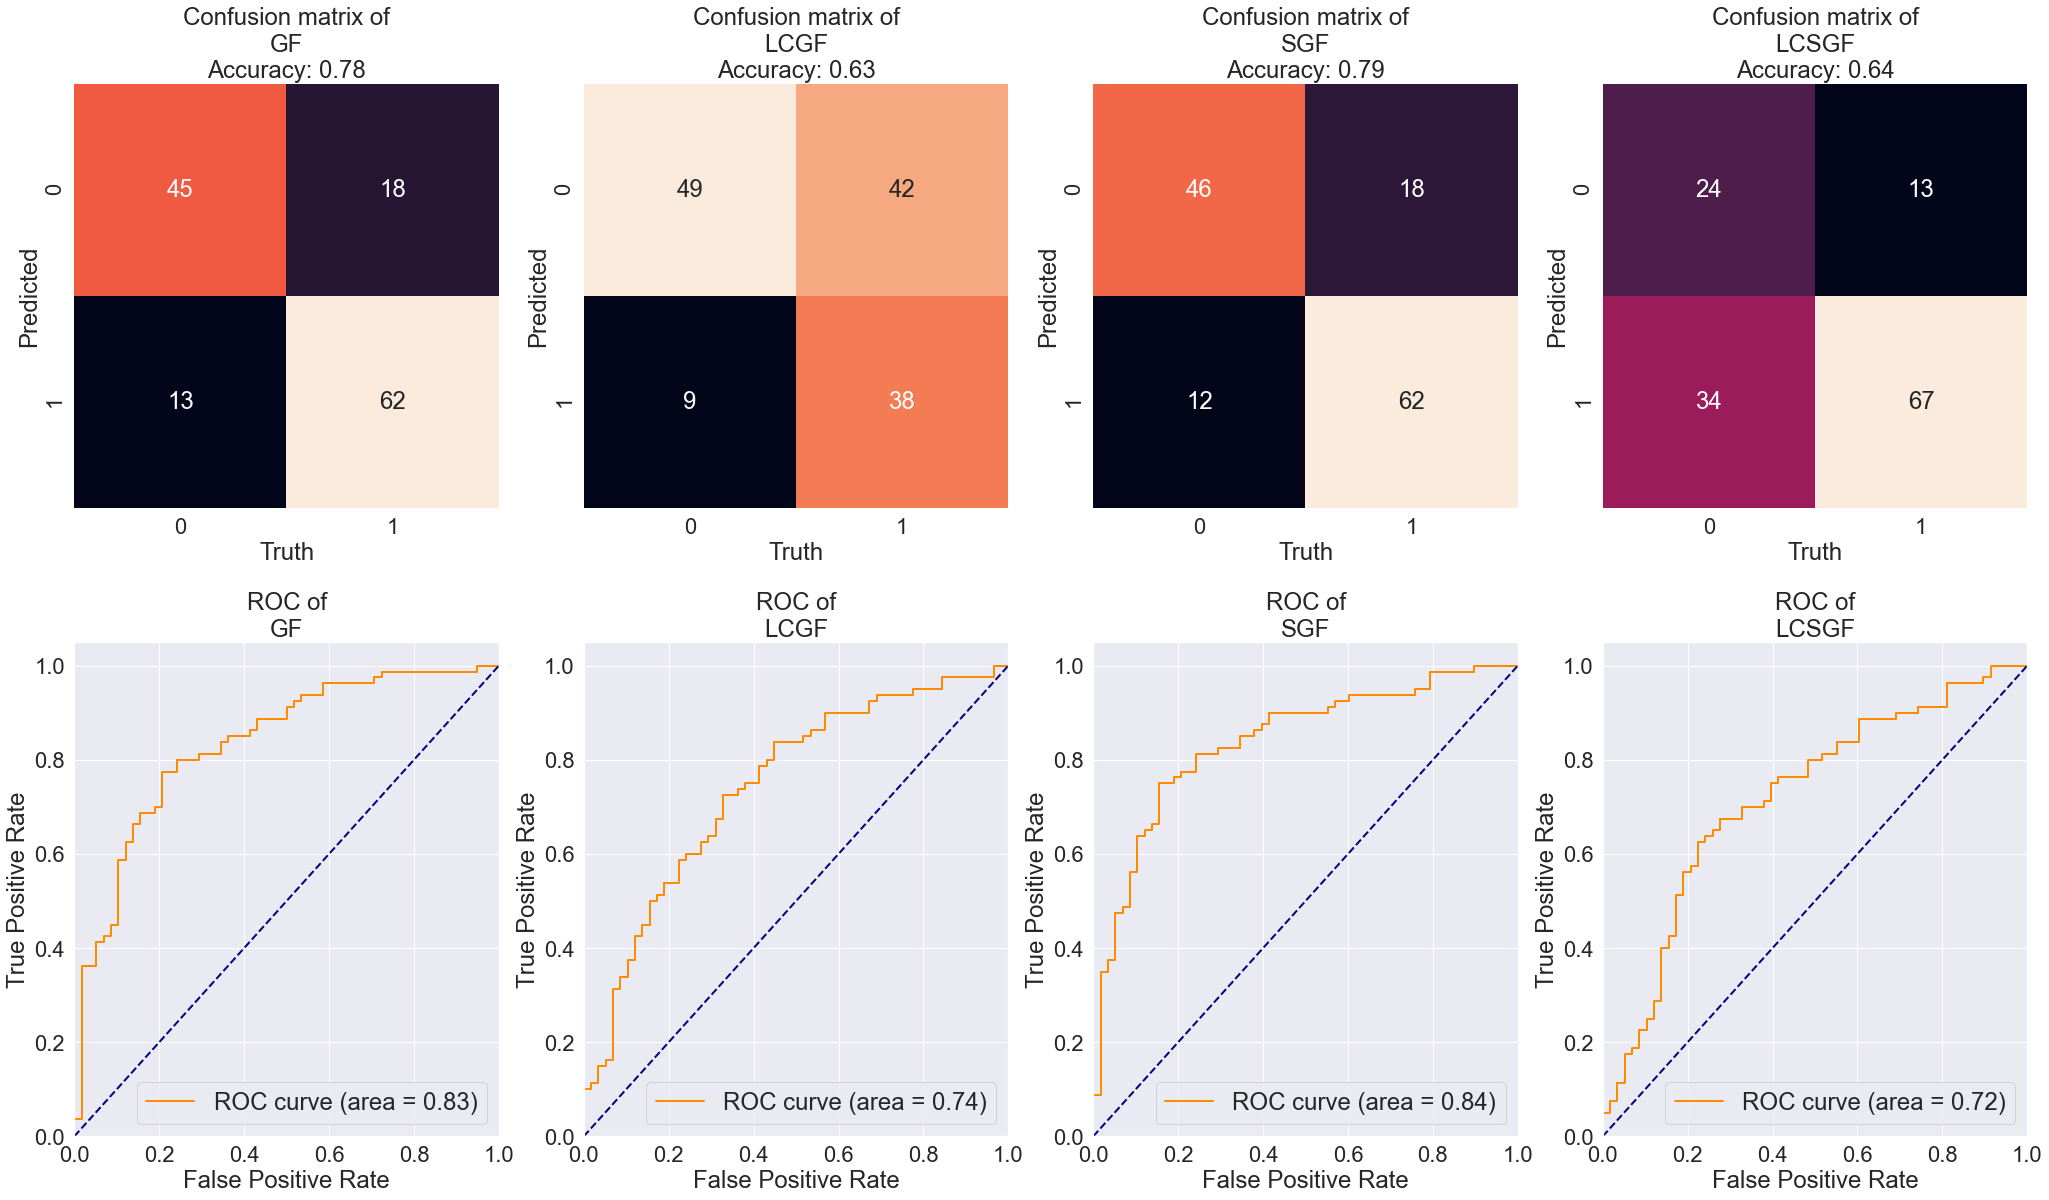

In [13]:
plt.clf()

figure, axes = plt.subplots(2,4)

figure.set_size_inches(35, 20)

###
# Confusion matrices
###

sns.set(font_scale=2)

# all data
mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names, ax=axes[0, 0])
axes[0, 0].set(xlabel='Truth',
                ylabel='Predicted',
                title='Confusion matrix of\nGF\nAccuracy: {:.2f}'.format(np.mean(cross_val_score(gnb, data.drop('class2', axis=1).values, data['class2'].values, cv=10)))) #np.mean(cross_val_score(gnb, data.drop('class2', axis=1).values, data['class2'].values, cv=10))   accuracy_score(y_test, y_pred)

# low correlation
mat_lowcorr = confusion_matrix(y_pred_lowcorr, y_test_lowcorr)
names_lowcorr = np.unique(y_pred_lowcorr)
sns.heatmap(mat_lowcorr, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_lowcorr, yticklabels=names_lowcorr, ax=axes[0, 1])
axes[0, 1].set(xlabel='Truth',
                ylabel='Predicted',
                title='Confusion matrix of\nLCGF\nAccuracy: {:.2f}'.format(np.mean(cross_val_score(gnb, data_low_corr.drop('class2', axis=1).values, data_low_corr['class2'].values, cv=10)))) # accuracy_score(y_test_lowcorr, y_pred_lowcorr)

# all standardized
mat_stdz = confusion_matrix(y_pred_stdz, y_test_stdz)
names_stdz = np.unique(y_pred_stdz)
sns.heatmap(mat_stdz, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_stdz, yticklabels=names_stdz, ax=axes[0, 2])
axes[0, 2].set(xlabel='Truth',
                ylabel='Predicted',
                title='Confusion matrix of\nSGF\nAccuracy: {:.2f}'.format(np.mean(cross_val_score(gnb, data_stdz.drop('class2', axis=1).values, data_stdz['class2'].values, cv=10)))) #np.mean(cross_val_score(gnb, data.drop('class2', axis=1).values, data['class2'].values, cv=10))   accuracy_score(y_test, y_pred)

# low correlation standardized
mat_lowcorr_stdz = confusion_matrix(y_pred_lowcorr_stdz, y_test_lowcorr_stdz)
names_lowcorr_stdz = np.unique(y_pred_lowcorr_stdz)
sns.heatmap(mat_lowcorr_stdz, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_lowcorr_stdz, yticklabels=names_lowcorr_stdz, ax=axes[0, 3])
axes[0, 3].set(xlabel='Truth',
                ylabel='Predicted',
                title='Confusion matrix of\nLCSGF\nAccuracy: {:.2f}'.format(np.mean(cross_val_score(gnb, data_low_corr_stdz.drop('class2', axis=1).values, data_low_corr_stdz['class2'].values, cv=10)))) # accuracy_score(y_test_lowcorr, y_pred_lowcorr)

###
# ROC curves
###

# sns.set(font_scale=2)
# plt.rcParams.update({'font.size': 1})

# all data
y_pred_prob = gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
lw = 2
axes[1, 0].plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
axes[1, 0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[1, 0].set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC of\nGF')
axes[1, 0].legend(loc='lower right', fontsize='medium')

# low correlation
y_pred_prob_lowcorr = gnb.fit(X_train_lowcorr, y_train_lowcorr).predict_proba(X_test_lowcorr)[:, 1]
fpr_lowcorr, tpr_lowcorr, _ = roc_curve(y_test_lowcorr, y_pred_prob_lowcorr)
roc_auc_lowcorr = roc_auc_score(y_test_lowcorr, y_pred_prob_lowcorr)
lw = 2
axes[1, 1].plot(fpr_lowcorr, tpr_lowcorr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc_lowcorr)
axes[1, 1].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[1, 1].set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC of\nLCGF')
axes[1, 1].legend(loc='lower right', fontsize='medium')

# all standardized
y_pred_prob_stdz = gnb.fit(X_train_stdz, y_train_stdz).predict_proba(X_test_stdz)[:, 1]
fpr_stdz, tpr_stdz, _ = roc_curve(y_test_stdz, y_pred_prob_stdz)
roc_auc_stdz = roc_auc_score(y_test_stdz, y_pred_prob_stdz)
lw = 2
axes[1, 2].plot(fpr_stdz, tpr_stdz, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc_stdz)
axes[1, 2].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[1, 2].set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC of\nSGF')
axes[1, 2].legend(loc='lower right', fontsize='medium')

# low correlation standardized
y_pred_prob_lowcorr_stdz = gnb.fit(X_train_lowcorr_stdz, y_train_lowcorr_stdz).predict_proba(X_test_lowcorr_stdz)[:, 1]
fpr_lowcorr_stdz, tpr_lowcorr_stdz, _ = roc_curve(y_test_lowcorr_stdz, y_pred_prob_lowcorr_stdz)
roc_auc_lowcorr_stdz = roc_auc_score(y_test_lowcorr_stdz, y_pred_prob_lowcorr_stdz)
lw = 2
axes[1, 3].plot(fpr_lowcorr_stdz,tpr_lowcorr_stdz,color="darkorange",lw=lw, label="ROC curve (area = %0.2f)" % roc_auc_lowcorr_stdz)
axes[1, 3].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[1, 3].set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC of\nLCSGF')
axes[1, 3].legend(loc='lower right', fontsize='medium')

## Feature selection.

Make k best feature selection object for all of the dataframes. Here k runs from 1 to # of features. These objects are later used to select the k best features.

In [14]:
# k_best = {}

# data_to_use = data

# predictors = data_to_use.drop('class2', axis=1).values
# predictable = data_to_use['class2'].values

# col_n = predictors.shape[1] + 1

# for i in range(1, col_n):
#     i_best = SelectKBest(f_classif, k=i)
#     k_best[str(i)] = i_best


In [15]:
data_frames = {'all': data, 'low corr': data_low_corr, 'all stdz': data_stdz, 'low corr stdz': data_low_corr_stdz}
k_bests = []

for name, df in data_frames.items():
    predictors = df.drop('class2', axis=1).values

    col_n = predictors.shape[1] + 1
    k_best = {}

    for i in range(1, col_n):
        i_best = SelectKBest(f_classif, k=i)
        k_best[str(i)] = i_best

    k_bests.append(k_best)

### Calculate accuracy and perplexity for each kBest feature using 10 fold crossvalidation for different prior probabilitites.

In [16]:
# # Using all of the variables except class2 (predictable variable) and class4
# def get_xy(df):
#     if ('class4' in df.columns.values):
#         df = df.drop('class4', axis=1)
#     X = df.drop('class2', axis=1).values
#     y = data['class2'].ravel()
#     return [X, y]

# def perplexity(y_true, y_pred_proba):
#     # return np.exp(-np.mean(np.log((y_true == 1) * y_pred_proba + (y_true == 0) * (1 - y_pred_proba))))
#     return np.exp(np.mean(log_loss(y_true, y_pred_proba)))

# use_k_best = True

# dict_to_use = k_best if use_k_best else data_dict # data_dict k_best

# kf = KFold(n_splits=10)

# eventPrios = []
# pred = np.zeros(shape=(9, len(dict_to_use)))
# perp = np.zeros(shape=(9, len(dict_to_use)))

# for i in range(1, 10):
#     prio = i/10
#     eventPrios.append(1-prio)
#     gnb = GaussianNB(priors=[prio, (1-prio)])

#     temp_pred = []
#     temp_perp = []
#     for value in dict_to_use.values():

#         kf = KFold(n_splits=10)
#         cv_accs = []
#         cv_perps = []

#         for train, test in kf.split(data_to_use):
#             x_values = value.fit_transform(predictors, predictable)
#             X_train, X_test, y_train, y_test = x_values[train], x_values[test], predictable[train], predictable[test]

#             y_pred = gnb.fit(X_train, y_train).predict(X_test)
#             cv_accs.append(accuracy_score(y_test, y_pred))

#             y_pred_prob = gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
#             cv_perps.append(perplexity(y_test, y_pred_prob))
        
#         temp_pred.append(np.mean(cv_accs))
#         temp_perp.append(np.mean(cv_perps))


#         # if use_k_best:
#         #     x_values = value.fit_transform(predictors, predictable)
#         #     X_train, X_test, y_train, y_test = train_test_split(x_values, predictable, test_size=0.3, random_state=0)
#         # else:
#         #     xy = get_xy(value)
#         #     X_train, X_test, y_train, y_test = train_test_split(xy[0], xy[1], test_size=0.3, random_state=0)
        
#         # y_pred = gnb.fit(X_train, y_train).predict(X_test)
#         # # temp_pred.append(accuracy_score(y_test, y_pred))
#         # temp_pred.append(np.mean(cross_val_score(gnb, x_values, predictable, cv=10)))

#         # y_pred_prob = gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
#         # temp_perp.append(perplexity(y_test, y_pred_prob))

#     pred[i-1] = np.array(temp_pred)
#     perp[i-1] = np.array(temp_perp)
    
    

In [17]:
def perplexity(y_true, y_pred_proba):
    # return np.exp(-np.mean(np.log((y_true == 1) * y_pred_proba + (y_true == 0) * (1 - y_pred_proba))))
    return np.exp(np.mean(log_loss(y_true, y_pred_proba)))

kf = KFold(n_splits=10)

eventPrios = []
preds = []
perps = []

for i, (name, df) in enumerate(data_frames.items()):

    pred = np.zeros(shape=(9, len(k_bests[i])))
    perp = np.zeros(shape=(9, len(k_bests[i])))
    predictors = df.drop('class2', axis=1).values
    predictable = df['class2'].values 

    for j in range(1, 10):
        prio = j/10
        if len(eventPrios) != 9:
            eventPrios.append(1-prio)
        gnb = GaussianNB(priors=[prio, (1-prio)])

        temp_pred = []
        temp_perp = []
        for k_best_i in k_bests[i].values():

            cv_accs = []
            cv_perps = []

            for train, test in kf.split(df): 
                x_values = k_best_i.fit_transform(predictors, predictable)
                X_train, X_test, y_train, y_test = x_values[train], x_values[test], predictable[train], predictable[test]

                model = gnb.fit(X_train, y_train)

                y_pred = model.predict(X_test)
                cv_accs.append(accuracy_score(y_test, y_pred))

                y_pred_prob = model.predict_proba(X_test)[:, 1]
                cv_perps.append(perplexity(y_test, y_pred_prob))
            
            temp_pred.append(np.mean(cv_accs))
            temp_perp.append(np.mean(cv_perps))

        pred[j-1] = np.array(temp_pred)
        perp[j-1] = np.array(temp_perp)
    preds.append(pred)
    perps.append(perp)

### Put results in new dataframe that contains accuracy and perplexity

In [18]:
def get_df_data(kbest, acc, prp):
    d = {}
    for i, key in enumerate(kbest):
        column_name = 'k = {}'.format(key)
        accu = column_name + ' acc'
        d[accu] = acc[:, i]
        perp = column_name + ' perp'
        d[perp] = prp[:, i]
    return d

result_dfs = []
for i in range(0, 4):
    df = pd.DataFrame(index=eventPrios, data=get_df_data(k_bests[i], preds[i], perps[i]))
    result_dfs.append(df)

### Keep only best performing kBest features.

Best performing are the ones that have lowest perplexity.

In [19]:
best_dfs = []
for df in result_dfs:
    # accuracy_df = df[[col for col in df.columns.values if 'acc' in col]]
    # columns_with_max_accuracy = list(accuracy_df.idxmax(axis=1).values)
    # best_accuracy = list(dict.fromkeys(columns_with_max_accuracy))
    # best_perp = [col[0:-4]+' perp' for col in best_accuracy]

    perpr_df = df[[col for col in df.columns.values if 'perp' in col]]
    columns_with_min_perplexity = list(perpr_df.idxmin(axis=1).values)
    best_perp = list(dict.fromkeys(columns_with_min_perplexity))
    best_accuracy = [col[0:-5]+' acc' for col in best_perp]


    best_columns = best_accuracy + best_perp

    best_columns.sort()

    best_dfs.append(df[best_columns])

## Show best kBest features

all data

In [20]:
best_dfs[0].rename(columns=lambda x: 'GF '+x, inplace=True)
best_dfs[0]

C:\Users\Jaykob\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,GF k = 1 acc,GF k = 1 perp,GF k = 2 acc,GF k = 2 perp
0.9,0.643816,2.435758,0.735604,2.400904
0.8,0.711546,1.966022,0.768406,2.101821
0.7,0.746618,1.795679,0.777246,1.989088
0.6,0.772995,1.722936,0.770821,1.939931
0.5,0.770870,1.704088,0.775266,1.927143
0.4,0.764396,1.730193,0.779614,1.945406
0.3,0.729614,1.812448,0.770870,2.002737
0.2,0.679710,1.999123,0.751353,2.132309
0.1,0.575121,2.509800,0.703671,2.482990


low correlation

In [21]:
best_dfs[1].rename(columns=lambda x: 'LCGF '+x, inplace=True)
best_dfs[1]

C:\Users\Jaykob\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,LCGF k = 3 acc,LCGF k = 3 perp
0.9,0.532174,2.961501
0.8,0.575990,2.270685
0.7,0.624348,2.011827
0.6,0.659517,1.896873
0.5,0.642126,1.861986
0.4,0.655217,1.893501
0.3,0.590048,2.006771
0.2,0.544396,2.269600
0.1,0.509710,2.987753


all standardized

In [22]:
best_dfs[2].rename(columns=lambda x: 'SGF '+x, inplace=True)
best_dfs[2]

C:\Users\Jaykob\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,SGF k = 1 acc,SGF k = 1 perp,SGF k = 2 acc,SGF k = 2 perp
0.9,0.643816,2.435758,0.735604,2.400904
0.8,0.711546,1.966022,0.768406,2.101821
0.7,0.746618,1.795679,0.777246,1.989088
0.6,0.772995,1.722936,0.770821,1.939931
0.5,0.770870,1.704088,0.775266,1.927143
0.4,0.764396,1.730193,0.779614,1.945406
0.3,0.729614,1.812448,0.770870,2.002737
0.2,0.679710,1.999123,0.751353,2.132309
0.1,0.575121,2.509800,0.703671,2.482990


low correlation standardized

In [23]:
best_dfs[3].rename(columns=lambda x: 'LCSGF '+x, inplace=True)
best_dfs[3]

C:\Users\Jaykob\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,LCSGF k = 2 acc,LCSGF k = 2 perp
0.9,0.564638,3.909197
0.8,0.580145,2.960295
0.7,0.598019,2.555337
0.6,0.635459,2.331447
0.5,0.657633,2.202611
0.4,0.655507,2.143604
0.3,0.635797,2.159143
0.2,0.527198,2.298379
0.1,0.501014,2.801109


In [24]:
all_result_df = pd.concat([best_dfs[0], best_dfs[2], best_dfs[1], best_dfs[3]], axis=1)
all_result_df

,GF k = 1 acc,GF k = 1 perp,GF k = 2 acc,GF k = 2 perp,SGF k = 1 acc,SGF k = 1 perp,SGF k = 2 acc,SGF k = 2 perp,LCGF k = 3 acc,LCGF k = 3 perp,LCSGF k = 2 acc,LCSGF k = 2 perp
0.9,0.643816,2.435758,0.735604,2.400904,0.643816,2.435758,0.735604,2.400904,0.532174,2.961501,0.564638,3.909197
0.8,0.711546,1.966022,0.768406,2.101821,0.711546,1.966022,0.768406,2.101821,0.575990,2.270685,0.580145,2.960295
0.7,0.746618,1.795679,0.777246,1.989088,0.746618,1.795679,0.777246,1.989088,0.624348,2.011827,0.598019,2.555337
0.6,0.772995,1.722936,0.770821,1.939931,0.772995,1.722936,0.770821,1.939931,0.659517,1.896873,0.635459,2.331447
0.5,0.770870,1.704088,0.775266,1.927143,0.770870,1.704088,0.775266,1.927143,0.642126,1.861986,0.657633,2.202611
0.4,0.764396,1.730193,0.779614,1.945406,0.764396,1.730193,0.779614,1.945406,0.655217,1.893501,0.655507,2.143604
0.3,0.729614,1.812448,0.770870,2.002737,0.729614,1.812448,0.770870,2.002737,0.590048,2.006771,0.635797,2.159143
0.2,0.679710,1.999123,0.751353,2.132309,0.679710,1.999123,0.751353,2.132309,0.544396,2.269600,0.527198,2.298379
0.1,0.575121,2.509800,0.703671,2.482990,0.575121,2.509800,0.703671,2.482990,0.509710,2.987753,0.501014,2.801109


## Plot information of the best data used

In [28]:
bestInd = 0
bestDf = best_dfs[bestInd]
dataframe = data

bestDf_perp = bestDf[[col for col in bestDf.columns.values if 'perp' in col]]
bestDf_acc = bestDf[[col for col in bestDf.columns.values if 'acc' in col]]

In [29]:
for i, col_name in enumerate(bestDf_perp):
    num_of_k = col_name[6:-4].strip()
    print('features for {}:'.format(col_name[3:-5].upper()))
    print(dataframe.columns.values[k_bests[bestInd][num_of_k].get_support(indices=True)], '\n')

features for K = 1:
['RHIRGA672.mean'] 

features for K = 2:
['RGlob.mean' 'RHIRGA672.mean'] 



### Show perpelxity for each kBest

<ipython-input-35-9d7931c036ec>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(pad=10.0)
<ipython-input-35-9d7931c036ec>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(pad=10.0)


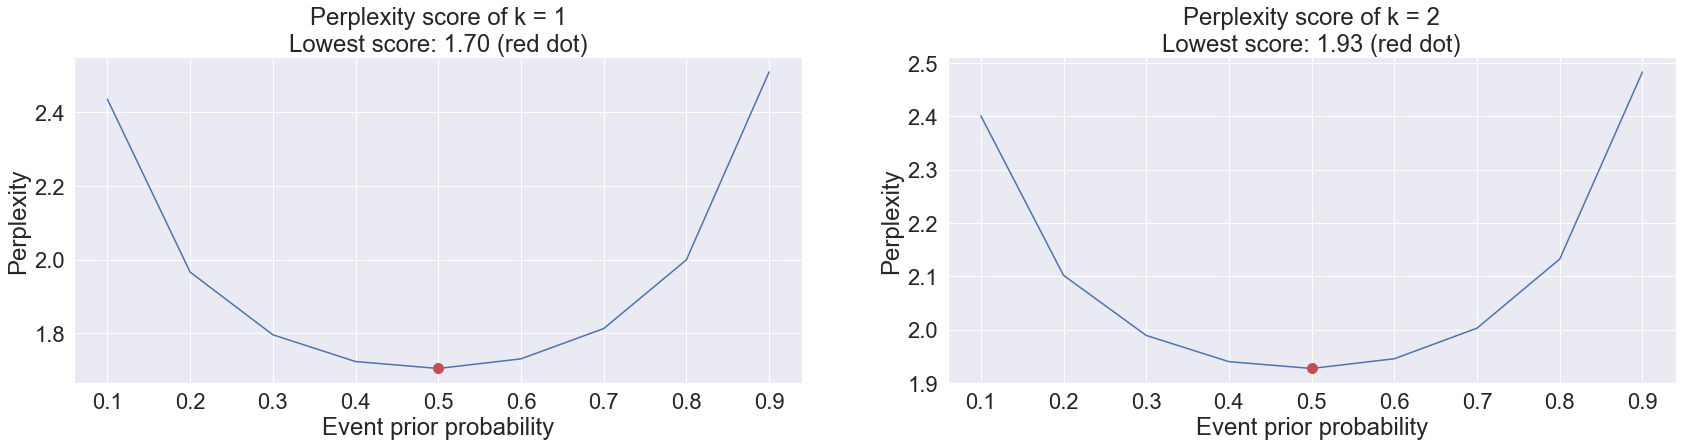

In [35]:
x_space = np.linspace(0.1, 0.9, 9)
n = len(list(bestDf.columns))

plt.subplots(figsize=(60, 6))
# plt.rcParams.update({'font.size': 2})

for i, col_name in enumerate(bestDf_perp):
    plt.subplot(1, n, i+1)
    plt.grid(True)
    plt.plot(x_space, bestDf_perp.loc[:, col_name].values)
    plt.plot(0.5, bestDf_perp.iloc[4, i], 'ro', markersize=10)
    plt.xlabel('Event prior probability')
    plt.ylabel('Perplexity')
    plt.title('Perplexity score of {}\nLowest score: {:.2f} {}'.format(col_name[3:-5], np.min(bestDf_perp.loc[:, col_name].values), '(red dot)'))
    plt.tight_layout(pad=10.0)

plt.show()

### Show accuracy plot for each kBest

<ipython-input-36-4f1db879635c>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(pad=10.0)
<ipython-input-36-4f1db879635c>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(pad=10.0)


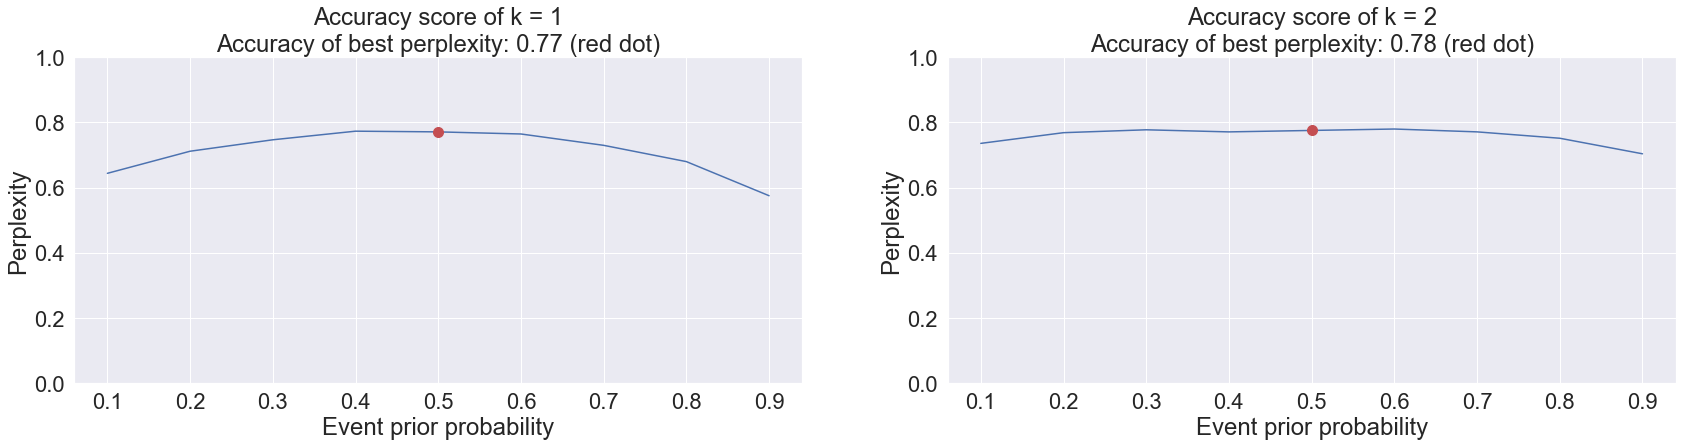

In [36]:
x_space = np.linspace(0.1, 0.9, 9)
n = len(list(bestDf.columns))

plt.subplots(figsize=(60, 6))

for i, col_name in enumerate(bestDf_acc):
    plt.subplot(1, n, i+1)
    plt.grid(True)
    plt.plot(x_space, bestDf_acc.loc[:, col_name].values)
    plt.plot(0.5, bestDf_acc.iloc[4, i], 'ro', markersize=10)
    plt.xlabel('Event prior probability')
    plt.ylabel('Perplexity')
    plt.title('Accuracy score of {}\nAccuracy of best perplexity: {:.2f} {}'.format(col_name[3:-4], bestDf_acc.iloc[4, i], '(red dot)'))
    plt.ylim([0.0, 1.0])
    plt.tight_layout(pad=10.0)

plt.show()

## Confusion matrices and ROC curves

Calculate values

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, col_name in enumerate(bestDf_perp):
    num_of_k = col_name[6:-4].strip()
    k_best_columns = dataframe.columns.values[k_bests[bestInd][num_of_k].get_support(indices=True)]
    features = dataframe[k_best_columns].values
    predictable = dataframe['class2'].ravel()
    X_train, X_test, y_train, y_test = train_test_split(features, predictable, test_size=0.3, random_state=0)
        
    y_pred_prob = gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]

    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob)
    roc_auc[i] = auc(fpr[i], tpr[i]) 

### Confusion matrices and ROC for best kBest features

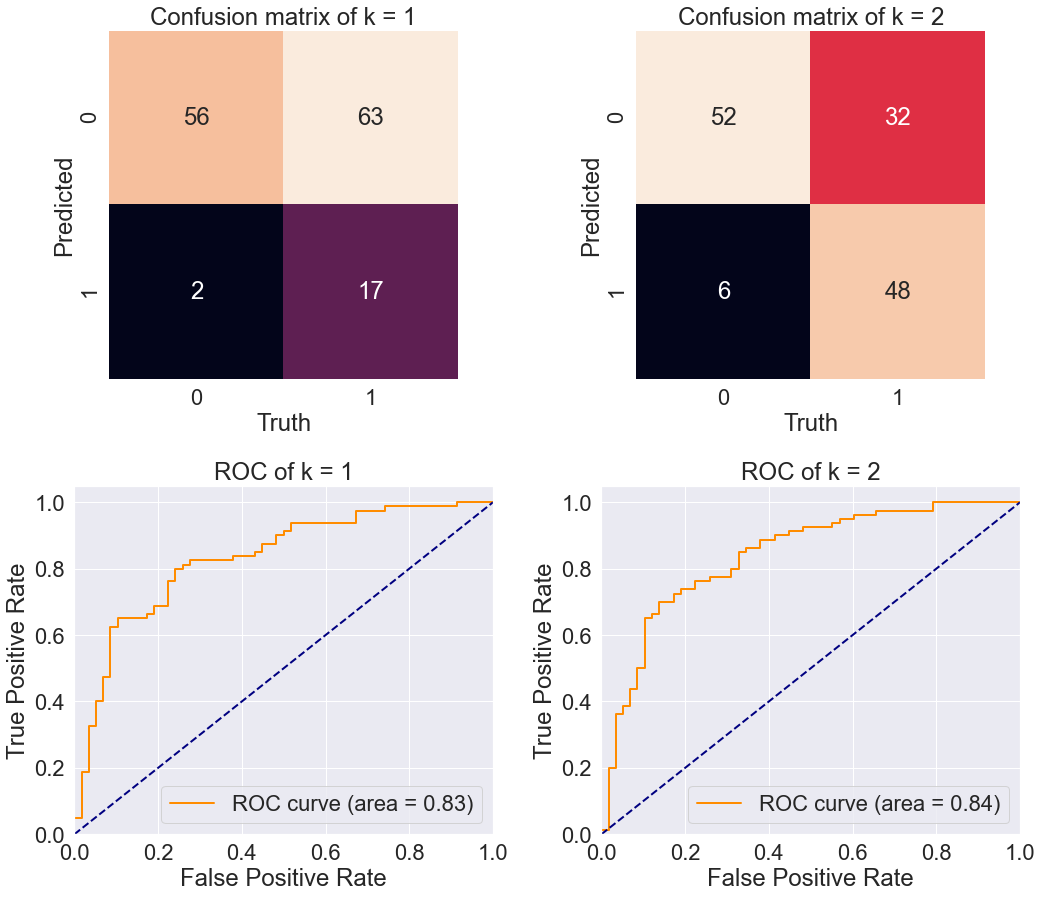

In [33]:
n = len(list(bestDf.columns))

plt.subplots(figsize=(15, 13))
sns.set(font_scale=2)

for i, col_name in enumerate(bestDf_perp):
    num_of_k = col_name[6:-4].strip()
    k_best_columns = dataframe.columns.values[k_bests[bestInd][num_of_k].get_support(indices=True)]
    features = dataframe[k_best_columns].values
    predictable = dataframe['class2'].ravel()
    X_train, X_test, y_train, y_test = train_test_split(features, predictable, test_size=0.3, random_state=0)
        
    y_pred_val = gnb.fit(X_train, y_train).predict(X_test)

    plt.subplot(2, 2, i+1)
    # Plot Confusion Matrix
    mat = confusion_matrix(y_pred_val, y_test)
    names = np.unique(y_pred_val)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=names, yticklabels=names)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix of {}'.format(col_name[3:-5]))
    plt.tight_layout()

    # Plot ROC
    roc_ind = 3 if i == 0 else 4
    plt.subplot(2, 2, roc_ind)
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC of {}".format(col_name[3:-5]))
    plt.legend(loc="lower right")
    plt.tight_layout()

plt.show()

ROC curves for kBest features

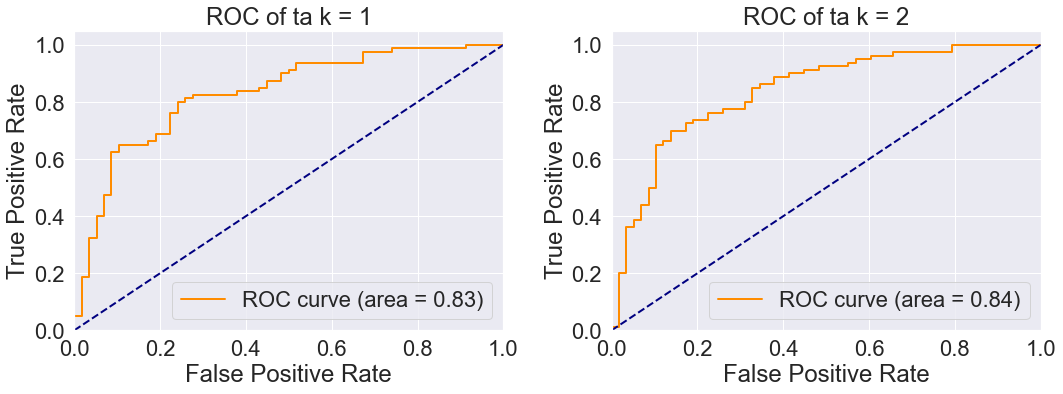

In [ ]:
n = len(list(bestDf.columns))

plt.subplots(figsize=(30, 6))

for i, col_name in enumerate(bestDf_perp):
    plt.subplot(1, n, i+1)
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC of {}".format(col_name[6:-5]))
    plt.legend(loc="lower right")
    plt.tight_layout()

plt.show()

# Summary

The best score seems to be when the select kBest = 1. These features are 'RHIRGA672.mean'.

For this model:

Accuracy = $0.77$	

Perplexity = $1.70$

Area under the ROC curve = $0.83$

Now concidering all of the above result this model is probably not best to choose for this classification task since the perplexity and accuracy could be better.

<Figure size 432x288 with 0 Axes>

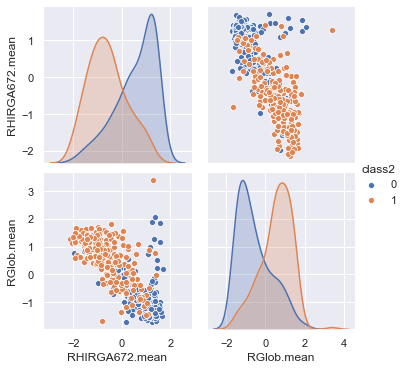

In [ ]:
best_features = ['RHIRGA672.mean', 'RGlob.mean', 'class2']
plt.clf()
sns.set(font_scale=1)
sns.pairplot(data_stdz[best_features], hue="class2")
plt.grid(False)
plt.show()

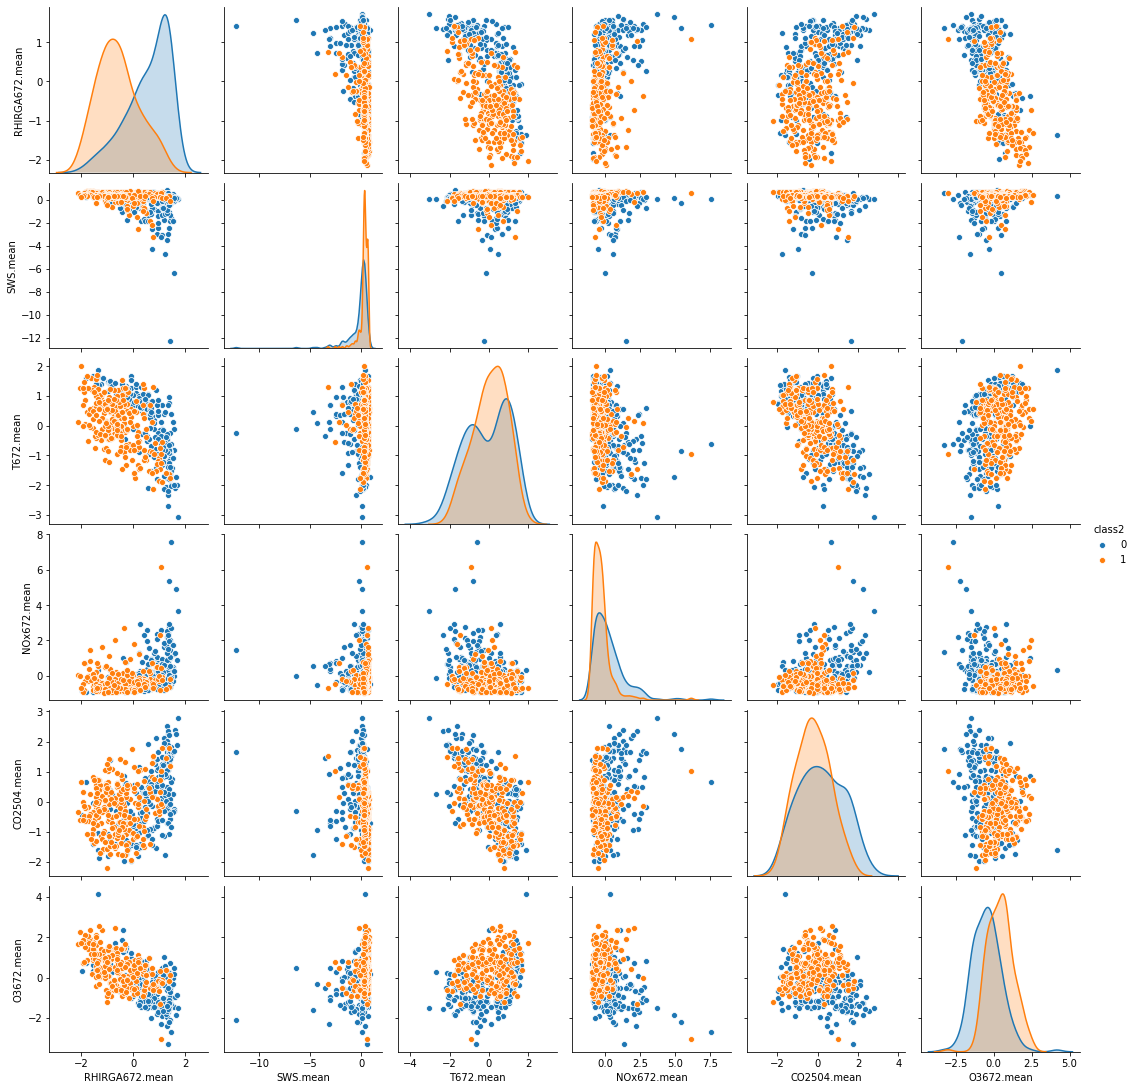

In [ ]:
best_features = ['RHIRGA672.mean', 'SWS.mean', 'T672.mean', 'NOx672.mean', 'CO2504.mean', 'O3672.mean', 'class2']
sns.pairplot(data_stdz[best_features], hue="class2")
plt.show()